In [1]:
from model import DenoisingUNet
from dataloaders import synthetic_mask_dataset
from torch.utils.data import DataLoader
from glob import glob
from utils import *
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np
sampleRate = 49.95

# Training on synthetic data

In [4]:
N_sub = 11
batch_size = 32
hidden_layers = 4
learning_rate = 5e-4
num_epochs = 2000
Nt = 2048

In [2]:
train_data = np.load("../data/synthetics/train/waveforms-train.npy")
test_data = np.load("../data/synthetics/test/waveforms-test.npy")

N_ch, N_t = train_data.shape
t_slice = slice(N_t//4, 3*N_t//4)

scaled_data_train = np.zeros_like(train_data)
scaled_data_test = np.zeros_like(test_data)

# Loop over data and normalise
for i, wv in enumerate(train_data):
    scaled_data_train[i] = wv / wv[t_slice].std()

# Loop over data and normalise
for i, wv in enumerate(test_data):
    scaled_data_test[i] = wv / wv[t_slice].std()   

In [5]:
train_dataset = synthetic_mask_dataset(scaled_data_train,Nt=Nt, N_sub=N_sub, batch_size=batch_size, batch_multiplier=5)
train_loader = DataLoader(train_dataset, batch_size=1, drop_last=True, shuffle=False)

test_dataset = synthetic_mask_dataset(scaled_data_test,Nt=Nt, N_sub=N_sub, batch_size=batch_size, batch_multiplier=5)
test_loader = DataLoader(test_dataset, batch_size=1, drop_last=True, shuffle=True)

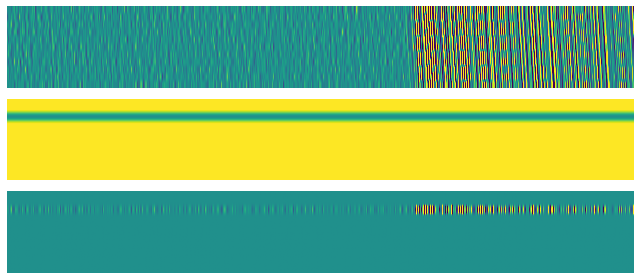

In [32]:
for (samples, masks), masked_samples in train_loader:
    samples = samples[0]
    masks = masks[0]
    masked_samples = masked_samples[0]
    break
# Draw canvas
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 4))

# Show sample (without blanking)
axes[0].imshow(samples[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[0].axis("off")

# Show mask
axes[1].imshow(masks[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[1].axis("off")

# Show prediction target
axes[2].imshow(masked_samples[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [33]:
# GPU
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is {device}.')

model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
model.to(device)
# Mean Square Error 
criterion = nn.MSELoss()

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NVIDIA GeForce RTX 2070
device is cuda:0.


In [34]:
epochs_losses_train = []
epochs_losses_val = []
for epoch in range(num_epochs):
    train_loader.dataset.__init__(scaled_data_train,Nt=Nt, N_sub=N_sub, batch_size=batch_size, batch_multiplier=5)
    batch_losses = []
    ## TRAIN ##
    for (samples, masks), masked_samples in train_loader:
        samples = samples[0].reshape(batch_size,1,N_sub,Nt).float().to(device)
        masks = masks[0].reshape(batch_size,1,N_sub,Nt).float().to(device)
        masked_samples = masked_samples[0].reshape(batch_size,1,N_sub,Nt).float().to(device)
        # apply mask
        sample = (samples * masks).clone().detach()
        optimizer.zero_grad()
        c_mask = 1-masks
        # apply complementary mask to output (proj. operator)
        output = model(sample)*c_mask
        loss = criterion(output, masked_samples)
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epochs_losses_train.append(np.mean(batch_losses))
    model.eval()
    eval_losses = []
    with torch.no_grad():
        for (samples, masks), masked_samples in test_loader:
            samples = samples[0].reshape(batch_size,1,N_sub,Nt).float().to(device)
            masks = masks[0].reshape(batch_size,1,N_sub,Nt).float().to(device)
            masked_samples = masked_samples[0].reshape(batch_size,1,N_sub,Nt).float().to(device)
            # apply mask
            sample = samples * masks.clone().detach()
            optimizer.zero_grad()
            c_mask = 1-masks
            # apply complementary mask to output (proj. operator)
            output = model(sample)*c_mask
            loss = criterion(output, masked_samples)
            eval_losses.append(loss.item())
        epochs_losses_val.append(np.mean(eval_losses))
    print(f"Epoch: {epoch} Training Loss: {np.mean(batch_losses)}, Validation Loss: {np.mean(eval_losses)}")
    if epoch % 200 == 0:
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
                }, f"..\\data\\runs\\synthetic-run\\checkpoint-epoch-{epoch}.pth")       
    

Epoch: 0 Training Loss: 0.089767459745162, Validation Loss: 0.08678570941642479
Epoch: 1 Training Loss: 0.07873583654655475, Validation Loss: 0.07256005042129093
Epoch: 2 Training Loss: 0.07014140702575167, Validation Loss: 0.06948428863176594
Epoch: 3 Training Loss: 0.06811459846446448, Validation Loss: 0.06831553812932085
Epoch: 4 Training Loss: 0.06664542860795404, Validation Loss: 0.06758502843203368
Epoch: 5 Training Loss: 0.06593279338607164, Validation Loss: 0.06673911117293217
Epoch: 6 Training Loss: 0.06510078123657503, Validation Loss: 0.0665872538531268
Epoch: 7 Training Loss: 0.06434632823846051, Validation Loss: 0.06590130069741497
Epoch: 8 Training Loss: 0.06449923277876088, Validation Loss: 0.06547172505546499
Epoch: 9 Training Loss: 0.06384738388462602, Validation Loss: 0.06529430796702702
Epoch: 10 Training Loss: 0.06304688344352713, Validation Loss: 0.06478853261581173
Epoch: 11 Training Loss: 0.06318054550161986, Validation Loss: 0.0647488937333778
Epoch: 12 Training

Text(0.5, 1.0, 'Validation MSE')

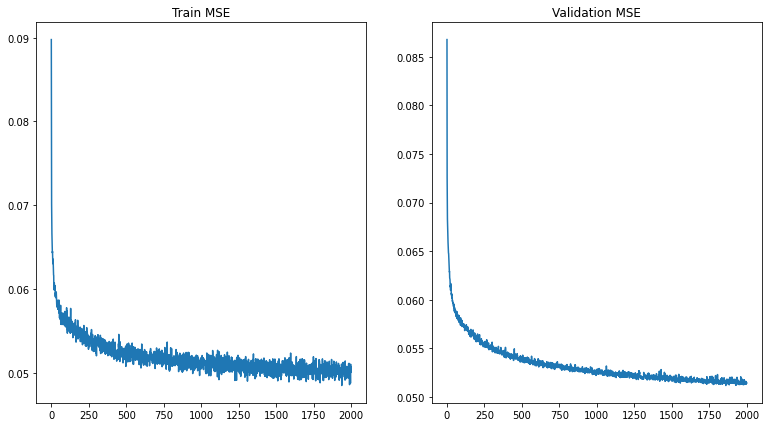

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13, 7))
ax1.plot(epochs_losses_train)
ax1.set_title("Train MSE")
ax2.plot(epochs_losses_val)
ax2.set_title("Validation MSE")

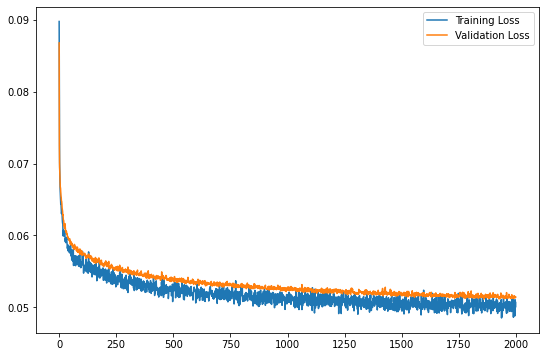

In [36]:
plt.figure(figsize=(9, 6))
plt.plot(epochs_losses_train, label='Training Loss')
plt.plot(epochs_losses_val, label='Validation Loss')
plt.legend()

In [37]:
# save final model
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
                }, f"..\\data\\runs\\synthetic-run\\final-2000.pth")